# Imagenette dataset

The dataset is stored under `./data/imagenette2`

In [2]:
#|export
import os
import shutil
import random
import torchvision
from torchvision.datasets.utils import download_and_extract_archive
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from export import serialize_fp32

In [3]:
#|export
base = "data"
os.makedirs(base, exist_ok=True)

url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz"
download_and_extract_archive(url, download_root=base, extract_root=base)

Using downloaded and verified file: data/imagenette2.tgz
Extracting data/imagenette2.tgz to data


In [4]:
#|export
# resize images into (3, 224, 224) and normalize
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])
dataset = ImageFolder(root="data/imagenette2/val", transform=transform)

# save transformed images to binary files
dst = "data/imagenette2/val_transformed"
os.makedirs(dst, exist_ok=True)

for i, (image, label) in enumerate(dataset):
    if i % 500 == 0:
        print(f"Wrote {i}/{len(dataset)}")

    dsd = os.path.join(dst, str(int(label)))
    os.makedirs(dsd, exist_ok=True)
    df = os.path.join(dsd, str(i))
    f = open(df, "wb")
    serialize_fp32(f, image)
    f.close()
print("Done")

Wrote 0/3925
Wrote 500/3925
Wrote 1000/3925
Wrote 1500/3925
Wrote 2000/3925
Wrote 2500/3925
Wrote 3000/3925
Wrote 3500/3925
Done


Image shape (nch, h, w): (3, 224, 224)


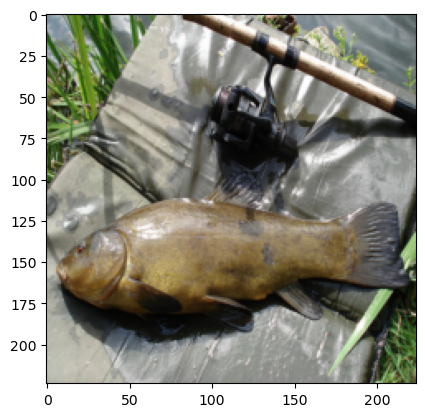

In [5]:
import matplotlib.pyplot as plt
import torch
import struct

f = open("data/imagenette2/val_transformed/0/0", "rb")
sizeof_float, nch, h, w = 4, 3, 224, 224
image = torch.tensor(struct.unpack("f"*(nch*h*w), f.read(sizeof_float*nch*h*w))).view(nch,h,w)
f.close()

# imshow accepts image shape (height, width, nch)
image_transposed = image.permute(1, 2, 0) 
plt.imshow(image_transposed)
print(f"Image shape (nch, h, w): {(nch, h, w)}")

In [6]:
#|export
# create directory containing the subset of `val_transformed`
src = "data/imagenette2/val_transformed"
dst = "data/imagenette2/val_transformed_subset"
if os.path.exists(dst):
    shutil.rmtree(dst)
os.makedirs(dst)
seed = 4
nsamples = 10

for label in range(10):
    ssd = os.path.join(src, str(label))
    dsd = os.path.join(dst, str(label))
    os.makedirs(dsd, exist_ok=True)

    # shuffle image files
    files = os.listdir(ssd)
    random.Random(seed).shuffle(files)

    # copy 10 samples to `val_transformed_subset`
    for f in files[:nsamples]:
        sf = os.path.join(ssd, f)
        df = os.path.join(dsd, f)
        shutil.copy(sf, df)